In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

from sklearn.model_selection import train_test_split

from utils import get_label, evaluate, Imputer, Vectorizer, Splitter

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [28]:
data = pd.read_csv("data/train.tsv", sep="\t")
x_train, x_test, y_train, y_test = train_test_split(data.drop("label", axis=1), get_label(data), random_state=RANDOM_SEED)
print("1s in a dataset: {:.2f}%".format(y_train.mean()*100))
x_train.head()

1s in a dataset: 8.05%


,statement,subject,speaker,speaker_job,state,party,context
10148,Nearly 65 percent -- almost two-thirds -- of a...,immigration,jeb-bush,NaN,Florida,republican,in his book 'Immigration Wars'
6904,"Says that except for foreign policy, Ron Pauls...",voting-record,paul-broun,Congressman,Georgia,republican,a fundraiser letter
1721,Ronald Reagan banned ownership of fully automa...,"guns,history",alfonso-lopez,State delegate,Virginia,democrat,a floor speech.
5466,Americans now support strikes (against ISIS) b...,"polls,terrorism",katrina-vanden-heuvel,NaN,NaN,none,"a panel on ABC's ""This Week"""
6794,"Amendment 2 will put almost 2,000 pot shops in...","florida-amendments,marijuana",vote-no-2,NaN,Florida,none,a video


# Speaker name

## Exploration

,index,speaker,count,lies
0,0,barack-obama,493,1.622718
1,1,donald-trump,274,18.978102
2,2,hillary-clinton,239,2.510460
3,3,mitt-romney,180,9.444444
4,4,scott-walker,150,5.333333
5,5,john-mccain,148,4.054054
6,6,chain-email,142,57.746479
7,7,rick-perry,142,11.267606
8,8,marco-rubio,117,1.709402
9,9,rick-scott,115,6.086957


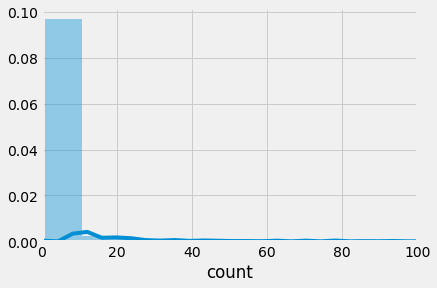

In [29]:
people = data.groupby("speaker").size().sort_values(ascending=False).reset_index().reset_index()
lies = [get_label(data.loc[data.speaker == name]).mean() * 100 for name in people.speaker]
people["lies"] = lies
people.columns = ["index", "speaker", "count", "lies"]

sns.distplot(people["count"])
plt.xlim((0, 100))
people.head(35)

In [30]:
data[data.speaker =="blog-posting"]
data[data.party == "none"].head()
# party może być none, ale osobą mówiącą może być osoba reputowana (nie tylko blog, facebook i inne memy)

,label,statement,subject,speaker,speaker_job,state,party,context
2,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release
12,mostly-true,The economy bled $24 billion due to the govern...,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,a Doonesbury strip in the Sunday comics
20,mostly-true,The United States has the highest corporate ta...,"corporations,taxes",eric-bolling,"Co-host on Fox News Channel's ""The Five""",NaN,none,"a discussion on Fox News' ""The Five"""
22,half-true,"Says Scott Walker favors cutting up to 350,000...","health-care,message-machine",greater-wisconsin-political-fund,NaN,Wisconsin,none,a campaign TV ad
23,barely-true,Says Mitt Romney wants to get rid of Planned P...,"abortion,federal-budget,health-care",planned-parenthood-action-fund,Advocacy group,"Washington, D.C.",none,a radio ad


In [31]:
def encode_popular(name, colname, common, *, top=40):
    encoding = np.zeros(top + 1)
    if name in common[:top][colname].values:
        idx = common.loc[common[colname]==name, "index"].values[0]
        encoding[idx] = 1
    else:
        encoding[top] = 1
    return encoding

In [32]:
encode_popular("blog-posting", "speaker", people, top=35)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [33]:
def encode_column(x_array, colname, most_popular, *, top=50):
    if type(x_array) == pd.core.series.Series:
        x_array = x_array.values
    ret = []
    for name in x_array:
        ret.append(encode_popular(name, colname, most_popular, top=top))
    return np.stack(ret)

def encode_speaker(x_array):
    return encode_column(x_array, "speaker", people)

from sklearn.preprocessing import FunctionTransformer
SpeakerEncoder = FunctionTransformer(encode_speaker)

## Evaluation of name encoding

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline, FeatureUnion

from utils import get_label, evaluate, Imputer, Vectorizer, Splitter

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [35]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("speaker_encoder", SpeakerEncoder, "speaker"),
        ("job", impute_vectorize, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("predict", LogisticRegression(max_iter=1000, C=0.9))
])

Accuracy: 91.59
F-1 score: 0.1148


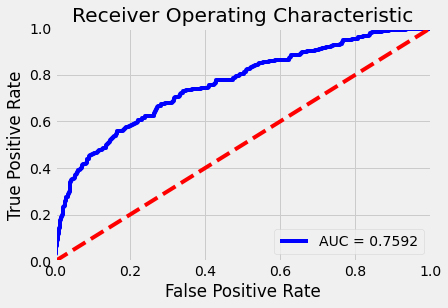

In [36]:
pipeline.fit(x_train, y_train)
evaluate(pipeline, x_test, y_test)

Improved F-1 score compared to baseline (quite significantly).

# Speaker job 

## Exploration

In [37]:
print(data.shape)
data.speaker_job.unique().__len__()

(10268, 8)


1188

In [38]:
colname = "speaker_job"
jobs = data.groupby(colname).size().sort_values(ascending=False).reset_index().reset_index()
lies = [get_label(data.loc[data[colname] == name]).mean() * 100 for name in jobs[colname]]
jobs["lies"] = lies
jobs.columns = ["index", colname, "count", "lies"]

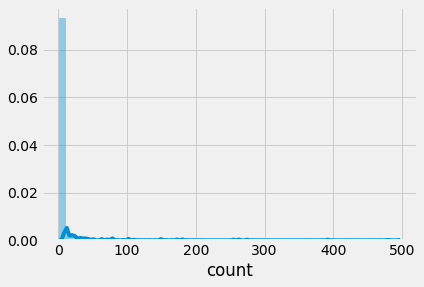

In [15]:
jobs.head(20)
sns.distplot(jobs["count"])

In [16]:
def encode_job(x_array):
    return encode_column(x_array, "speaker_job", jobs, top=60)

JobEncoder = FunctionTransformer(encode_job)

In [17]:
encode_popular("U.S. senator", "speaker_job", jobs)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

## Evaluation of jobs encoding

In [25]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

impute_encode_job = Pipeline([
    ("imputer", Imputer), ("vectorizer", JobEncoder)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("speaker_encoder", SpeakerEncoder, "speaker"),
        ("job", impute_encode_job, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("predict", LogisticRegression(max_iter=1000, C=0.9))
])

Accuracy: 91.59
F-1 score: 0.1148


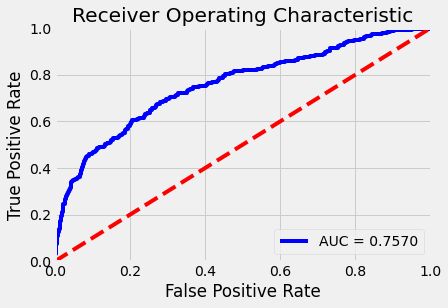

In [26]:
pipeline.fit(x_train, y_train)
evaluate(pipeline, x_test, y_test)

Job encoding didn't give us anything unfortunately (it's not clear wether job encoding alone improves baseline score).

# Party

In [20]:
data.party.unique()

array(['democrat', 'none', 'republican', 'organization', 'independent',
       'columnist', 'activist', 'talk-show-host', 'libertarian',
       'newsmaker', 'journalist', 'labor-leader', 'state-official',
       'business-leader', 'education-official', 'tea-party-member',
       'green', 'liberal-party-canada', 'government-body', 'Moderate',
       'democratic-farmer-labor', 'ocean-state-tea-party-action',
       'constitution-party'], dtype=object)